In [28]:
import tensorflow as tf
import numpy as np

class PGGCN(tf.keras.Model):
    def __init__(self,):
        super(PGGCN, self).__init__()

    def call(self, inputs, training=False):
        atom_features = inputs[0]
        degree_slice = tf.cast(inputs[1], dtype=tf.int32)
        membership = tf.cast(inputs[2], dtype=tf.int32)
        n_samples = tf.cast(inputs[3], dtype=tf.int32)
        deg_adjs = [tf.cast(deg_adj, dtype=tf.int32) for deg_adj in inputs[4:]]

In [29]:
# !curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
# conda_installer.install()
conda_installer.install()
# !/root/miniconda/bin/conda info -e

all packages are already installed


In [30]:
import rdkit
import deepchem as dc
from rdkit import Chem

In [31]:
co2 = Chem.MolFromSmiles('C(=O)=O')
ethanol = Chem.MolFromSmiles('CCO')
benzene = Chem.MolFromSmiles('c1ccccc1')

In [32]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)

In [33]:
co2_f = featurizer(co2)[0]
ethanol_f = featurizer(ethanol)[0]
benzene_f = featurizer(benzene)[0]
mols = [co2_f, ethanol_f, benzene_f]

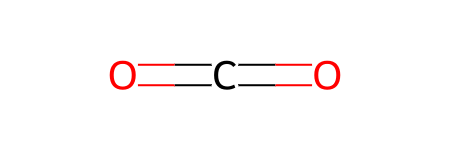

In [46]:
co2

In [51]:
a = np.array([[1, 2], [3, 4]])

In [50]:
co2_f.deg_slice

array([[0, 0],
       [0, 2],
       [2, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)

In [49]:
co2_f.deg_slice[1, 1]

2

In [35]:
ethanol_f.degree_list

[1, 1, 2]

In [59]:
benzene_f.deg_adj_lists

[array([], shape=(0, 0), dtype=int32),
 array([], shape=(0, 1), dtype=int32),
 array([[1, 5],
        [0, 2],
        [1, 3],
        [2, 4],
        [3, 5],
        [4, 0]], dtype=int32),
 array([], shape=(0, 3), dtype=int32),
 array([], shape=(0, 4), dtype=int32),
 array([], shape=(0, 5), dtype=int32),
 array([], shape=(0, 6), dtype=int32),
 array([], shape=(0, 7), dtype=int32),
 array([], shape=(0, 8), dtype=int32),
 array([], shape=(0, 9), dtype=int32),
 array([], shape=(0, 10), dtype=int32)]

In [37]:
from deepchem.feat.mol_graphs import ConvMol
multiConvMol = ConvMol.agglomerate_mols(mols)

In [38]:
multiConvMol.membership

array([0, 0, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2], dtype=int32)

In [60]:
multiConvMol.deg_slice

array([[ 0,  0],
       [ 0,  4],
       [ 4,  8],
       [12,  0],
       [12,  0],
       [12,  0],
       [12,  0],
       [12,  0],
       [12,  0],
       [12,  0],
       [12,  0]])

In [58]:
multiConvMol.deg_adj_lists

[array([], shape=(0, 0), dtype=int32),
 array([[4],
        [4],
        [5],
        [5]], dtype=int32),
 array([[ 0,  1],
        [ 2,  3],
        [ 7, 11],
        [ 6,  8],
        [ 7,  9],
        [ 8, 10],
        [ 9, 11],
        [10,  6]], dtype=int32),
 array([], shape=(0, 3), dtype=int32),
 array([], shape=(0, 4), dtype=int32),
 array([], shape=(0, 5), dtype=int32),
 array([], shape=(0, 6), dtype=int32),
 array([], shape=(0, 7), dtype=int32),
 array([], shape=(0, 8), dtype=int32),
 array([], shape=(0, 9), dtype=int32),
 array([], shape=(0, 10), dtype=int32)]

In [40]:
num_mols = len(mols)
atoms_by_deg = np.concatenate([x.atom_features for x in mols])
degree_vector = np.concatenate([x.degree_list for x in mols], axis=0)

In [41]:
order = degree_vector.argsort(kind='mergesort')

In [42]:
ordered = np.empty(order.shape, np.int32)
ordered[order] = np.arange(order.shape[0], dtype=np.int32)

In [27]:
mol_atom_map = []
index_start = 0
for mol in mols:
    mol_atom_map.append(
      ordered[index_start:index_start + mol.get_num_atoms()])
    index_start += mol.get_num_atoms()

In [23]:
mol_atom_map

[array([0, 1, 4], dtype=int32),
 array([2, 3, 5], dtype=int32),
 array([ 6,  7,  8,  9, 10, 11], dtype=int32)]

In [24]:
max_deg = 10
min_deg = 0
mol_deg_sz = np.zeros([max_deg - min_deg + 1, num_mols], dtype=np.int32)
for i, mol in enumerate(mols):
    mol_deg_sz[:, i] += mol.deg_slice[:, 1]

In [25]:
deg_sizes = np.sum(mol_deg_sz, axis=1)

In [35]:
deg_sizes

array([0, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0])